# Hopfield Network GPU

In [5]:
import sys
import os
import numpy as np
import cupy as cp
import cv2
import matplotlib.pyplot as plt

### Settings

In [88]:
image_name = "github.png"  # Pattern image
P = 1000  # Number of pattern
M0 = 0.6  # Initial m^0
DELTA_M = 0.001  # Convergence threshold for M0 (m^0)
MAX_STEPS = 100  # Max step for recalling

### Memorize

In [89]:
# Open Image
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
if image is None:
    print(f"[Error] Cannot open \"{image_name}\"")
    sys.exit(-1)
xi0 = cp.where(cp.asarray(image.reshape(-1)) == 255, 1, -1)
N = xi0.size
width = image[0].size
height = N // width

# Create matrix J
cp.random.seed(np.uint64(1234))
xi = cp.random.choice([-1, 1], size=(P, N))
J = (cp.outer(xi0, xi0) + xi.T @ xi) / N

### Recall

In [92]:
# Resize function to fit image to FHD while preserving aspect ratio
def resize_to_fhd(image):
    # Calculate scale to maintain aspect ratio
    scale = min(1920 / width, 1080 / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    fhd_image = np.zeros((1080, 1920), dtype=np.uint8)

    x_offset = (1920 - new_width) // 2
    y_offset = (1080 - new_height) // 2
    fhd_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image

    return fhd_image

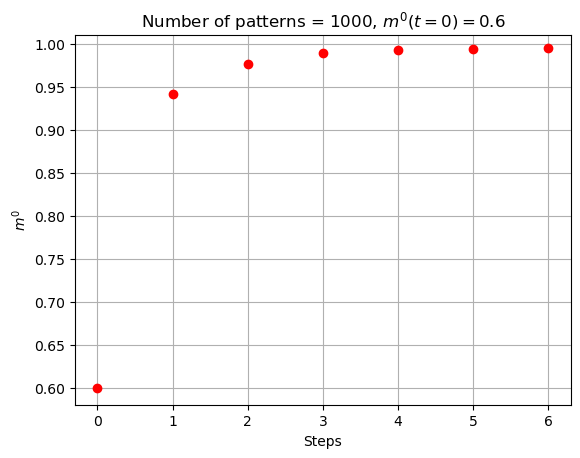

In [95]:
# Initial state setup
s = xi0.copy()
indices = cp.random.choice(N, size=int(N * (1 - M0) / 2), replace=False)
s[indices] = -s[indices]

m = [float(cp.dot(xi0, s) / N)]

# Prepare video file
outname = f'{os.path.splitext(os.path.basename(image_name))[0]}_P_{P}_M0_{M0}.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(outname, fourcc, 1, (1920, 1080), isColor=False)
if not video.isOpened():
    print(f"[Error] Cannot open \"{outname}\"")
    sys.exit(-1)

# Write initial state
video.write(resize_to_fhd(cp.where(s.reshape((height, width)) == 1, 255, 0).get().astype(np.uint8)))

# Steps
for _ in range(MAX_STEPS):
    s = cp.where((J @ s) >= 0, 1, -1)
    video.write(resize_to_fhd(cp.where(s.reshape((height, width)) == 1, 255, 0).get().astype(np.uint8)))
    m.append(float(cp.dot(xi0, s) / N))
    if cp.abs(m[-1] - m[-2]) <= DELTA_M:
        break

video.release()

# Plot results
fig, ax = plt.subplots()
ax.grid()
ax.set_title(f'Number of patterns = {P}, $m^0(t=0) = ${M0}')
ax.plot(np.arange(len(m)), m, 'ro')
ax.set_xlabel('Steps')
ax.set_ylabel('$m^0$')
ax.set_ylim(top=1.01)
plt.show()